In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [2]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [3]:
# creating a table for order activity
sql = '''
select id, date(created_at), verb, driver_id, order_id, "text"
from ctms_db_public.activities_orderactivity ao
WHERE date(created_at) >= date(current_date - interval '28 days')
AND date(created_at) < date(current_date)
AND verb = 'assigned'
'''
order_activity = pd.read_sql_query(sql, con=engine)
order_activity = order_activity.rename(columns={'id': 'activity_id', 'date': 'created_at'})
order_activity

,activity_id,created_at,verb,driver_id,order_id,text
0,48096084,2020-12-22,assigned,57713,7841345,Assigned to Lamont Edwards
1,48098548,2020-12-22,assigned,48379,3646884,Assigned to Uchkunbek Karshiev
2,48101012,2020-12-22,assigned,4150,7842296,Assigned to RIMANTAS JANULIS(LOCAL DRIVER)
3,48103476,2020-12-22,assigned,68707,7732991,Assigned to Albert Gaitan (LOCAL CA)
4,48107788,2020-12-22,assigned,22974,7845407,Assigned to Brett Vanous
...,...,...,...,...,...,...
211459,49205269,2021-01-18,assigned,29912,7813985,Assigned to Tolibjon
211460,49205349,2021-01-18,assigned,65882,8025119,Assigned to Shi Fowler
211461,49205413,2021-01-18,assigned,55461,8025396,"Assigned to DA Hodge, Doug"
211462,49205445,2021-01-18,assigned,84607,7995136,Assigned to Carl Galloway


In [4]:
# percentage of missing values
order_activity.isna().sum()/order_activity.isna().count()

activity_id    0.0
created_at     0.0
verb           0.0
driver_id      0.0
order_id       0.0
text           0.0
dtype: float64

In [5]:
# value counts of order activities after dropping missing values
order_activity['verb'].value_counts()

assigned    211464
Name: verb, dtype: int64

In [6]:
# creating a table of drivers to get driver guid
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid', 'genericuser_ptr_id': 'driver_id'})
drivers.head()

,driver_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df


In [7]:
# joining driver_guid to order activity table

order_activity = order_activity.merge(drivers, how='inner', left_on='driver_id', right_on='driver_id')
order_activity

,activity_id,created_at,verb,driver_id,order_id,text,carrier_id,driver_guid
0,48096084,2020-12-22,assigned,57713,7841345,Assigned to Lamont Edwards,14751,c1142064-fe7a-481f-ba1b-13c4b7fb65b1
1,48453368,2021-01-02,assigned,57713,7899029,Assigned to Lamont Edwards,14751,c1142064-fe7a-481f-ba1b-13c4b7fb65b1
2,48304420,2020-12-28,assigned,57713,7868648,Assigned to Lamont Edwards,14751,c1142064-fe7a-481f-ba1b-13c4b7fb65b1
3,48287066,2020-12-28,assigned,57713,7839732,Assigned to Lamont Edwards,14751,c1142064-fe7a-481f-ba1b-13c4b7fb65b1
4,48096165,2020-12-22,assigned,57713,7843476,Assigned to Lamont Edwards,14751,c1142064-fe7a-481f-ba1b-13c4b7fb65b1
...,...,...,...,...,...,...,...,...
208331,49192168,2021-01-18,assigned,71209,8023211,Assigned to Carol Arnold,450,471dd244-fdde-4d76-af91-29f3b16674c1
208332,49198321,2021-01-18,assigned,82897,8024259,Assigned to Dale,33224,bd0ba60a-dae8-4c4e-bafc-9a32db2a3a6f
208333,49203246,2021-01-18,assigned,33518,8025033,Assigned to Tulga Amar,22907,364c112b-62e6-449b-ad18-9ddad3476b07
208334,49205486,2021-01-18,assigned,39745,8025401,Assigned to Tangela Williams,26214,d83830de-d702-49a7-a8c2-e142622b1afc


In [30]:
result = order_activity.groupby(['driver_id', 'driver_guid', 'carrier_id']).nunique()[['created_at']]
result.reset_index(inplace=True)
result = result.rename(columns={'created_at': 'unique_days_of_assigning_load'})
result

,driver_id,driver_guid,carrier_id,unique_days_of_assigning_load
0,145,a705dfef-bd67-45d4-91cd-648673fade63,166,7
1,154,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,75,3
2,174,27abbc41-fa85-46c9-9545-418a2fd2d05a,86,8
3,175,95b49d52-c6bb-4ff1-afb0-ab58b9708970,88,17
4,186,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,105,16
...,...,...,...,...
10655,85749,e9078383-f20a-469b-8b00-7e7fa6a28d6c,44309,1
10656,85752,8da56389-c908-49ec-897c-32e6c193f340,25598,1
10657,85753,9b3c1992-72df-4aee-b873-d60a44947ba7,44514,1
10658,85755,ced6efe9-5927-48e5-899e-1ad8467a2e85,24212,1


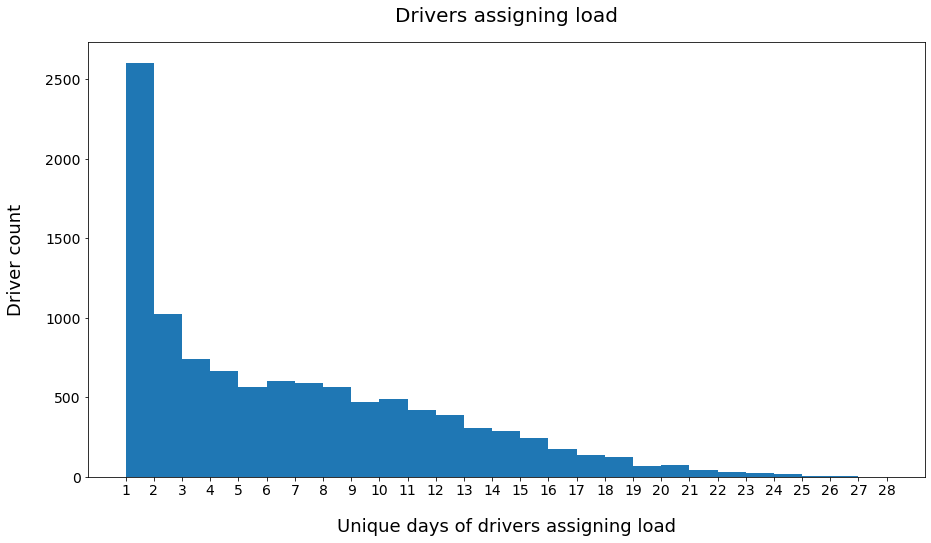

In [26]:
# histogram of unique days of driver activity (drivers assigned load)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_of_assigning_load'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days of drivers assigning load', fontsize=18, labelpad=20)
plt.ylabel('Driver count', fontsize=18, labelpad=20)
plt.title('Drivers assigning load', fontsize=20, pad=20)
plt.show()

# Now let's segment paid and free users

In [11]:
# creating a table for braintree subscriptions
sql = '''
DROP TABLE IF EXISTS #carrier_with_latest_sub_date
;
SELECT 
carrier_id
,max(created_at) AS last_sub
INTO #carrier_with_latest_sub_date
FROM ctms_db_public.billing_braintreesubscription
WHERE braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
GROUP BY carrier_id
;
SELECT 
#carrier_with_latest_sub_date.carrier_id
,last_sub
,braintree_subscription_status
FROM #carrier_with_latest_sub_date
JOIN ctms_db_public.billing_braintreesubscription
ON #carrier_with_latest_sub_date.carrier_id = billing_braintreesubscription.carrier_id
AND #carrier_with_latest_sub_date.last_sub = billing_braintreesubscription.created_at
WHERE billing_braintreesubscription.braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
;
'''
braintree_subs = pd.read_sql_query(sql, con=engine)
braintree_subs

,carrier_id,last_sub,braintree_subscription_status
0,5466,2016-11-26 09:21:35.868856,Active
1,3298,2016-11-26 09:21:30.983747,Active
2,4925,2017-01-20 15:19:46.097090,Active
3,1421,2017-05-18 13:42:02.182933,Active
4,433,2017-06-19 19:32:44.584252,Active
...,...,...,...
2866,14072,2021-01-18 19:13:08.675679,Active
2867,4554,2021-01-18 19:44:05.227397,Active
2868,40497,2021-01-18 23:06:56.706775,Active
2869,41621,2021-01-18 23:49:41.427665,Active


In [12]:
# creating a carriers table
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
WHERE test_account = False
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid'})
carriers

,name,carrier_id,carrier_guid
0,929 Transport LLC,41,8c22eb31-dc0c-4e51-9c10-c4de461d4ae8
1,Outstanding Auto Transport,45,f0fa8056-bea4-4205-9d5a-1eddddf8bbdb
2,GET IT THERE TRANSPORTING,65,2583471f-0a01-4768-9c13-876acb237c2f
3,JC Services,79,129e0f53-d4ae-4365-8c7e-fb9338be7b0e
4,Middle bay auto transport,88,af54a172-e9d3-4c23-8696-de0c303bfb23
...,...,...,...
40891,SMITH AUTO TRANSPORT,32770,e2ddafd8-c53b-463e-ba0c-106056aa9eaa
40892,TRUCKIT365 LLC,37205,a1671f0e-302c-42e8-a2cf-2fd42ba84740
40893,SUNSPHERE TRANSPORTATION AND LOGISTICS LLC,40324,5bd114f6-85af-4ced-9da4-5896ac9a3be0
40894,CARMEN & BUTCH TRUCKING COMPANY LLC,44517,3277653c-25fc-4420-bf9b-9f71d7078026


In [13]:
# joining carriers with braintree table

braintree_with_carriers = braintree_subs.merge(carriers, left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers
paid_carriers = braintree_with_carriers
paid_carriers

,carrier_id,last_sub,braintree_subscription_status,name,carrier_guid
0,5466,2016-11-26 09:21:35.868856,Active,Rob's Auto Transport LLC,101ce8ba-b529-43c1-80bf-c0f6939ba2a3
1,3298,2016-11-26 09:21:30.983747,Active,Rhoades Logistics LLC,7196d66a-cd25-4ae4-bcdb-15f01b895c2e
2,4925,2017-01-20 15:19:46.097090,Active,Double Time Transport,533c4db9-1f0e-4da2-83e1-ed1385508496
3,1421,2017-05-18 13:42:02.182933,Active,"L&N Transport, LLC",4ba23995-f6ad-4efa-86f8-e3d14d4d9e32
4,433,2017-06-19 19:32:44.584252,Active,FRANK MESSINA,525f3fe2-61bf-452b-b5dd-2ff269a05231
...,...,...,...,...,...
2866,14072,2021-01-18 19:13:08.675679,Active,ABA Logistics,9802165b-65e2-4d34-a9e7-1f9d3001a841
2867,4554,2021-01-18 19:44:05.227397,Active,DB TRANSPORT LLC,f3c31466-8ad6-4624-b14c-035e943b1012
2868,40497,2021-01-18 23:06:56.706775,Active,JGRAM TRANSPORTATION LLC,005ac507-176d-4806-888e-c23ea5df80b9
2869,41621,2021-01-18 23:49:41.427665,Active,PH AUTO TRANSPORT LLC,126dea7c-d499-4a51-b014-a013e21c0231


In [14]:
paid_drivers = drivers.merge(paid_carriers, left_on='carrier_id', right_on='carrier_id')
paid_drivers

,driver_id,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,782,361,385501a9-2116-415c-8698-cc380c6830cb,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
1,781,361,1c1503e2-a908-48f4-a880-ed528efd3b12,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
2,10352,361,e98aca37-2003-4a02-b4f6-76ba9061849b,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
3,4032,361,370aff85-faa5-4a65-a921-08ce62f1bfda,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
4,11663,361,eb3c0740-972a-47b6-a922-048184bbe962,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
...,...,...,...,...,...,...,...
12142,7410,4347,c47914ad-5a86-416b-8f24-e1d413fe02f0,2016-11-26 09:21:34.350835,Active,G & D Trucking of Illinois Inc.,f8bc0c21-3b78-4913-804c-f78f04f3ca46
12143,34017,23172,59badc3d-7f65-49d2-8934-85e5d1f555f3,2018-12-25 18:16:44.657729,Active,STANDARD TOWING & TRANSPORT,f6ebd6f5-ebfa-42f8-9849-1235aef3ee11
12144,42299,27544,a0007ed8-ed8a-40a6-a18f-ca19342a97ae,2019-06-11 17:29:42.565170,Active,PERFECT TIMING TOWING,a0315d89-0730-4a71-8ee9-43e2c568dabc
12145,56652,34459,4044b68d-cf05-497f-998f-71c75cb988eb,2020-01-15 21:06:37.672882,Active,AUTOGREEN INC,09594ef3-e1dc-4f52-87f5-da0515b8dbb3


In [15]:
free_drivers = drivers.merge(paid_carriers, how='left', left_on='carrier_id', right_on='carrier_id')
# getting all free users
non_payers = free_drivers['braintree_subscription_status'].isna() == True
#dropping all rows with paid users
free_drivers = free_drivers[non_payers]
free_drivers

,driver_id,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4,NaT,NaN,NaN,NaN
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d,NaT,NaN,NaN,NaN
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0,NaT,NaN,NaN,NaN
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347,NaT,NaN,NaN,NaN
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
62962,80946,38749,3402310c-7fad-42cb-bbc3-0485023c9e51,NaT,NaN,NaN,NaN
62965,84148,335,a2a9bffd-dc33-4411-9d13-f748aaca8a13,NaT,NaN,NaN,NaN
62967,84776,44078,fa2bfa7d-4d78-4c0b-ab54-da4817be1c4e,NaT,NaN,NaN,NaN
62970,85760,33856,eec1309f-341a-4120-b3f3-c83fb1e8c76f,NaT,NaN,NaN,NaN


# Paid users

In [31]:
result_paid_users = result.merge(braintree_with_carriers, left_on='carrier_id', right_on='carrier_id')
result_paid_users = result_paid_users[['driver_id', 'driver_guid', 'unique_days_of_assigning_load']]
result_paid_users

,driver_id,driver_guid,unique_days_of_assigning_load
0,145,a705dfef-bd67-45d4-91cd-648673fade63,7
1,1389,409fd000-524e-4c58-8b1d-bdf1c3ffcb11,4
2,1616,f77d50be-9014-4310-b779-2cecdb20dcea,11
3,1617,f857715d-c58e-47b3-8116-e8e603da8439,10
4,1686,4fb8e8a0-42d9-4719-b821-d805edd98866,7
...,...,...,...
5239,85562,3ac8726c-d002-4a27-96aa-133787bc9c50,1
5240,85563,1c12d167-d7ce-46d2-b088-9ff6a8f49461,1
5241,85564,fdd4df59-2b21-4b64-b799-0bed05bded84,1
5242,85579,f485b5f5-fe36-448e-badf-ae423f6fcc79,1


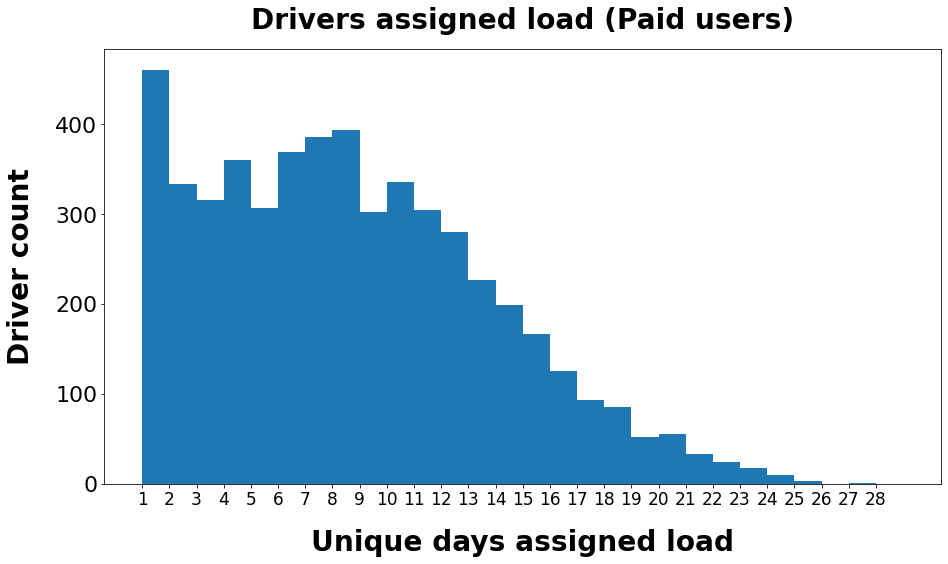

In [32]:
# histogram of unique assigned loads in last 28 days (to drivers)
plt.figure(figsize=(15,8))
plt.hist(result_paid_users['unique_days_of_assigning_load'], bins=np.arange(1, 30))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days assigned load', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('Drivers assigned load (Paid users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Free users

In [34]:
result_free_users = result.merge(braintree_with_carriers, how='left', left_on='carrier_id', right_on='carrier_id')
# Free users are when braintree subscription is null
non_payers = result_free_users['braintree_subscription_status'].isna() == True
#dropping all paid user rows
result_free_users = result_free_users[non_payers]
result_free_users = result_free_users[['driver_id', 'driver_guid', 'unique_days_of_assigning_load']]
result_free_users

,driver_id,driver_guid,unique_days_of_assigning_load
1,154,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,3
2,174,27abbc41-fa85-46c9-9545-418a2fd2d05a,8
3,175,95b49d52-c6bb-4ff1-afb0-ab58b9708970,17
4,186,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,16
5,213,733216f1-6987-4c63-9cb6-14189c9b8b43,6
...,...,...,...
10654,85748,a177e775-2bbe-474b-a644-145981d56f89,1
10655,85749,e9078383-f20a-469b-8b00-7e7fa6a28d6c,1
10656,85752,8da56389-c908-49ec-897c-32e6c193f340,1
10657,85753,9b3c1992-72df-4aee-b873-d60a44947ba7,1


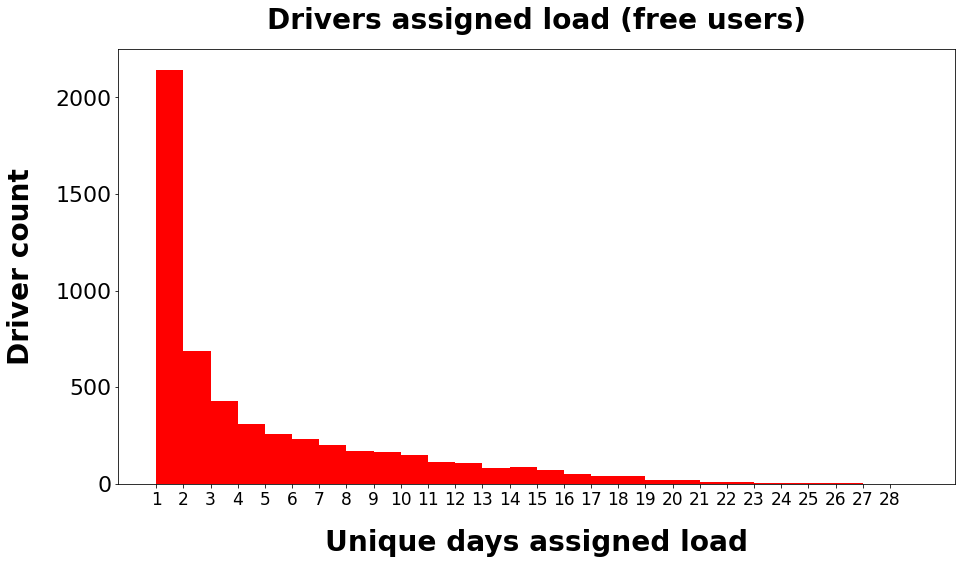

In [36]:
# histogram of unique assigned loads in last 28 days (to drivers)
plt.figure(figsize=(15,8))
plt.hist(result_free_users['unique_days_of_assigning_load'], bins=np.arange(1, 30), color='red')
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days assigned load', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('Drivers assigned load (free users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

In [38]:
total_paid_drivers_for_days_active = []

for i in range(1,29):
    paid_active_driver_count = (result_paid_users[result_paid_users['unique_days_of_assigning_load'] >= i]
                           .groupby('unique_days_of_assigning_load').count()['driver_guid'].sum())
    
    total_paid_drivers_for_days_active.append(paid_active_driver_count)
    


total_free_drivers_for_days_active = []

for i in range(1,29):
    free_active_driver_count = (result_free_users[result_free_users['unique_days_of_assigning_load'] >= i]
                           .groupby('unique_days_of_assigning_load').count()['driver_guid'].sum())
    
    total_free_drivers_for_days_active.append(free_active_driver_count)

In [39]:
paid_active_drivers = pd.DataFrame()
paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_drivers['total_drivers_at_least_this_active'] = total_paid_drivers_for_days_active
paid_active_drivers['total_percentage_active'] = round(100*paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(result_paid_users))
paid_active_drivers['total_percentage_dormant'] = 100 - paid_active_drivers['total_percentage_active']


free_active_drivers = pd.DataFrame()
free_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_drivers['total_drivers_at_least_this_active'] = total_free_drivers_for_days_active
free_active_drivers['total_percentage_active'] = round(100*free_active_drivers['total_drivers_at_least_this_active']
                                                       /len(result_free_users))
free_active_drivers['total_percentage_dormant'] = 100 - free_active_drivers['total_percentage_active']

In [40]:
def paid_vs_free(paid_metric_definition, free_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'],
                           (paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
assigned load
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    free_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_drivers.loc[free_metric_definition, 'total_drivers_at_least_this_active'],
                           (free_active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            free_active_drivers.loc[free_metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in free_graph.patches:
        free_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        free_graph.annotate('{}%'.format(round(100*p.get_height()/free_active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
assigned load
(non-paid users)'''.format(free_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

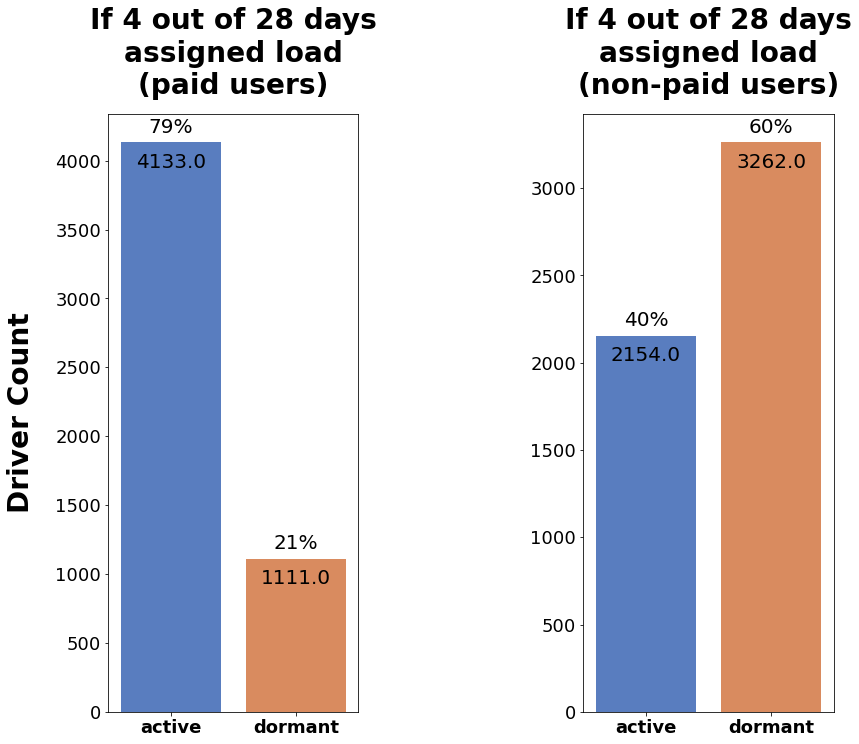

In [45]:
paid_vs_free(4, 4)

In [42]:
paid_active_drivers = pd.DataFrame()
paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_drivers['total_drivers_at_least_this_active'] = total_paid_drivers_for_days_active
paid_active_drivers['total_dormant_drivers'] = ([len(paid_drivers) - total_paid_drivers_for_days_active[x]
                                                 for x in range(len(total_paid_drivers_for_days_active))])
paid_active_drivers['total_percentage_active'] = round(100*paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(paid_drivers))
paid_active_drivers['total_percentage_dormant'] = 100 - paid_active_drivers['total_percentage_active']

free_active_drivers = pd.DataFrame()
free_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_drivers['total_drivers_at_least_this_active'] = total_free_drivers_for_days_active
free_active_drivers['total_dormant_drivers'] = ([len(free_drivers) - total_free_drivers_for_days_active[x]
                                                 for x in range(len(total_free_drivers_for_days_active))])
free_active_drivers['total_percentage_active'] = round(100*free_active_drivers['total_drivers_at_least_this_active']
                                                       /len(free_drivers))
free_active_drivers['total_percentage_dormant'] = 100 - free_active_drivers['total_percentage_active']

In [43]:
def all_users(paid_metric_definition, non_paid_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'],
                           paid_active_drivers.loc[paid_metric_definition, 'total_dormant_drivers']],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(paid_drivers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
assigned load
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_drivers.loc[non_paid_metric_definition, 'total_drivers_at_least_this_active'], 
                           free_active_drivers.loc[non_paid_metric_definition, 'total_dormant_drivers']],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(free_drivers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
assigned load
(free users)'''.format(non_paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

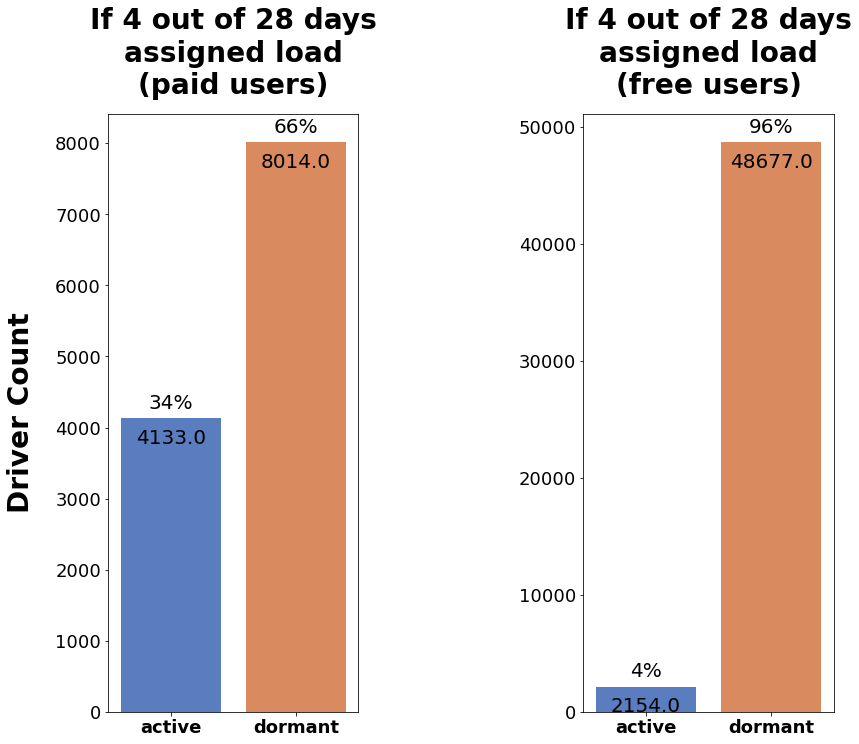

In [44]:
# bar charts that include "0 frequency" users
all_users(4, 4)